In [1]:
import os
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.2.1
      /_/

Using Python version 3.8.8 (default, Apr 13 2021 12:59:45)
Spark context Web UI available at http://akhileshs-mbp.lan:4040
Spark context available as 'sc' (master = local[*], app id = local-1652152319195).
SparkSession available as 'spark'.


In [2]:
import pyspark
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName("Churn Prediction").getOrCreate()
spark.sparkContext.setLogLevel('INFO')

In [3]:
spark.sparkContext.setLogLevel('ERROR')

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.driver.memory', '12g'),
 ('spark.sql.warehouse.dir',
  'file:/Users/akhilesh/college/Big%20Data/Project/spark-warehouse'),
 ('spark.driver.host', 'akhileshs-mbp.lan'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.app.startTime', '1652152318365'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.app.id', 'local-1652152319195'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '57959'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
!pip install jupyter_utils

In [6]:
from datetime import datetime

import numpy as np

from sklearn.metrics import confusion_matrix

from pyspark.sql import SparkSession

from pyspark.sql.functions import min as smin, max as smax, sum as ssum, round as sround, abs as sabs, pow as spow
from pyspark.sql.functions import isnan, isnull, when, first, avg, sqrt, last, count, countDistinct, col, lag, lead, coalesce, lit, split, trim

from pyspark.sql.window import Window
from pyspark.sql.functions import to_date, date_format, from_unixtime, to_timestamp

from pyspark.sql.types import DateType, TimestampType, IntegerType
 
import jupyter_utils as j

from pyspark import SparkContext

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, MaxAbsScaler, Normalizer, MinMaxScaler, StringIndexer, VectorAssembler

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator
from pyspark import since, keyword_only

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report

In [7]:
j.reload(j)

# Load Data 

In [8]:
def spark_read(spark):
    return spark.read.option('inferSchema', 'true').option('header', 'true').option('encoding', 'utf-8')

In [9]:
def load_full_json_file(spark):
    df = spark_read(spark).json('sparkify_event_data.json')
    return df

In [10]:
df = load_full_json_file(spark)

In [11]:
df.cache()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [12]:
from pyspark import StorageLevel

log4jLogger = spark.sparkContext._jvm.org.apache.log4j

LOGGER = log4jLogger.LogManager.getLogger('driver_logger')

def info(message, print_on_notebook = True):
    LOGGER.info(message)
    
    if print_on_notebook:
        print(message)
        
def set_storage_on_memory(df):
    df.persist(StorageLevel.MEMORY_ONLY)
    info('Storage set to MEMORY_ONLY')

info('Logger instance created')

set_storage_on_memory(df)

Logger instance created
Storage set to MEMORY_ONLY


In [13]:
df.count()

26259199

In [14]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Data Cleaning

### Considering records for logged in user sessions. Thus, removing guest or logged out users as we would not be able to obtain future sessions for these user IDs

In [15]:
df.select('auth').distinct().collect()

[Row(auth='Logged Out'),
 Row(auth='Cancelled'),
 Row(auth='Guest'),
 Row(auth='Logged In')]

In [16]:
df.where(df.auth.isin(['Guest', 'Logged Out'])).count()

778479

### Checking if records have user IDs present or not ?

In [17]:
df.where(col('userId').isNull()).count()

0

# Creating a new user columns based on the page analysis and its timestamp. Creating a window and extracting the featrure set 

In [18]:
df = df.where(df.auth.isin(['Logged In', 'Cancelled']))
df = df.withColumn('date', from_unixtime(col('ts') / 1000).cast(DateType()))

In [19]:
w_session = Window.partitionBy('sessionId').orderBy('ts')
df = df.withColumn('previous_page', lag(df.page).over(w_session))


In [20]:
w_user = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn('last_event_ts', last(col('ts')).over(w_user))

In [21]:
df = df.withColumn('last_page', last(col('page')).over(w_user))
df = df.withColumn('register_page', first(col('previous_page')).over(w_user))
df = df.withColumn('first_ts', first(col('ts')).over(w_user))

In [22]:
w_user_session = Window.partitionBy('sessionId', 'userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn('ts_elapsed', last(df.ts).over(w_session) - first(df.ts).over(w_user_session))
df = df.withColumn('session_duration', smax(df.ts_elapsed).over(w_user_session))

In [23]:
df.limit(20).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,userAgent,userId,date,previous_page,last_event_ts,last_page,register_page,first_ts,ts_elapsed,session_duration
0,None,Logged In,Ethan,M,0,Raymond,NaN,free,"Hartford-West Hartford-East Hartford, CT",GET,...,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1528635,2018-10-01,None,1543412707000,Roll Advert,None,1538400348000,0,1365000
1,3OH!3,Logged In,Ethan,M,1,Raymond,196.28363,free,"Hartford-West Hartford-East Hartford, CT",PUT,...,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1528635,2018-10-01,Home,1543412707000,Roll Advert,None,1538400348000,32000,1365000
2,Eminem,Logged In,Ethan,M,2,Raymond,251.55873,free,"Hartford-West Hartford-East Hartford, CT",PUT,...,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1528635,2018-10-01,NextSong,1543412707000,Roll Advert,None,1538400348000,228000,1365000
3,Bebel Gilberto,Logged In,Ethan,M,3,Raymond,389.58975,free,"Hartford-West Hartford-East Hartford, CT",PUT,...,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1528635,2018-10-01,NextSong,1543412707000,Roll Advert,None,1538400348000,479000,1365000
4,GHINZU,Logged In,Ethan,M,4,Raymond,209.44934,free,"Hartford-West Hartford-East Hartford, CT",PUT,...,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1528635,2018-10-01,NextSong,1543412707000,Roll Advert,None,1538400348000,868000,1365000
5,Flipsyde,Logged In,Ethan,M,5,Raymond,236.56444,free,"Hartford-West Hartford-East Hartford, CT",PUT,...,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1528635,2018-10-01,NextSong,1543412707000,Roll Advert,None,1538400348000,1077000,1365000
6,Jin,Logged In,Ethan,M,6,Raymond,117.36771,free,"Hartford-West Hartford-East Hartford, CT",PUT,...,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1528635,2018-10-01,NextSong,1543412707000,Roll Advert,None,1538400348000,1313000,1365000
7,None,Logged In,Ethan,M,7,Raymond,NaN,free,"Hartford-West Hartford-East Hartford, CT",GET,...,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1528635,2018-10-01,NextSong,1543412707000,Roll Advert,None,1538400348000,1365000,1365000
8,None,Logged In,Bruce,M,2,Wright,NaN,free,"Champaign-Urbana, IL",GET,...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1192388,2018-10-18,Cancellation Confirmation,1543005266000,Cancellation Confirmation,Cancellation Confirmation,1539871112000,0,10923000
9,La Polla Records,Logged In,Bruce,M,3,Wright,93.93587,free,"Champaign-Urbana, IL",PUT,...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1192388,2018-10-18,Home,1543005266000,Cancellation Confirmation,Cancellation Confirmation,1539871112000,2000,10923000


# Exploratory Data Analysis

#### When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

#### Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.

### Explore Data

#### Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [24]:
df.groupBy('page').count().orderBy('count', ascending = False).show(50)

+--------------------+--------+
|                page|   count|
+--------------------+--------+
|            NextSong|20850272|
|           Thumbs Up| 1151465|
|                Home|  933124|
|     Add to Playlist|  597921|
|         Roll Advert|  385212|
|          Add Friend|  381664|
|              Logout|  296005|
|         Thumbs Down|  239212|
|           Downgrade|  184240|
|            Settings|  147074|
|                Help|  129448|
|             Upgrade|   50507|
|               About|   48377|
|       Save Settings|   29516|
|               Error|   25048|
|      Submit Upgrade|   15135|
|    Submit Downgrade|    6494|
|              Cancel|    5003|
|Cancellation Conf...|    5003|
+--------------------+--------+



#### Some questions about the data:
Are errors related to downgrading canceling the service?
Having a certain number of friends or a sense of community can decrease the churn?
Thumbs down are related to churn? (could the quality of the songs catalog affect the churn)
The advertising is not annoying the users?
Users with stay connected for more time have less change to churn?
Is the home page relevant?
Users who access the downgrade page are how much more willing to churn?

In [25]:
df.groupBy('status').count().orderBy('count', ascending = False).show(20)

+------+--------+
|status|   count|
+------+--------+
|   200|23331178|
|   307| 2124494|
|   404|   25048|
+------+--------+



# Feature Engineering

## User Session (Count of each oage visit as feature set for new data)


In [26]:
df_sessions = df.orderBy(df.sessionId).groupBy('sessionId', 'userId').agg(
        smax(df.ts).alias('max_event_ts'),
        smin(df.ts).alias('min_event_ts'),
        ssum(df.length).alias('session_n_total_playback'), # Based on songs length
        count(when(df.page == 'Thumbs Up', True)).alias("session_n_likes"),
        count(when(df.page == 'Thumbs Down', True)).alias("session_n_dislikes"),
        count(when(df.page == 'NextSong', True)).alias("session_n_songs"),
        count(when(df.page == 'Add Friend', True)).alias("session_n_friends"),
        count(when(df.page == 'Add to Playlist', True)).alias("session_n_add_playlist"),
        count(when(df.page == 'Home', True)).alias("session_n_home"),
        count(when(df.page == 'Roll Advert', True)).alias("session_n_ads"),
        count(when(df.page == 'Help', True)).alias("session_n_help"),
        count(when(df.page == 'Error', True)).alias("session_n_error"),
        count(when(df.page == 'Settings', True)).alias("session_n_sets"),
        count(col('page')).alias('session_n_actions'),
        first(col('session_duration')).alias('session_duration')
    ) 

### Interval until next session  (Adding the interval between sessions as an feature )

In [27]:
w_user_sessions_interval = Window.partitionBy('userId').orderBy('min_event_ts')
df_sessions = df_sessions.withColumn('interval_to_session', col('min_event_ts') - lag(col('max_event_ts')).over(w_user_sessions_interval))

### Average time in hours for each session

In [28]:
milliseconds_to_hours = 3600 * 1000
minutes_to_hours = 60 * 60
TRUE = 1
FALSE = 0

### Adding the average playback time as a feature to check how users have played songs per session 

In [29]:
df_session_time = df_sessions.groupBy('userId').agg(
(avg(df_sessions.session_n_total_playback) / minutes_to_hours).alias('avg_playback_time'))

df_sessions = df_sessions.join(df_session_time, on = 'userId')

### Removing null lines before count/group

In [30]:
 df_sessions = df_sessions.groupBy('userId').agg(  
        (((smax(col('max_event_ts')) - smin(col('min_event_ts'))) / milliseconds_to_hours) / (ssum(df_sessions.session_n_total_playback) / minutes_to_hours) ).alias('time_window_over_playback_time'),
        (first(col('avg_playback_time'))).alias('avg_playback_time'),
        (avg(df_sessions.interval_to_session) / milliseconds_to_hours).alias('session_avg_time_away'),
        (avg(df_sessions.session_n_likes) / first(col('avg_playback_time'))).alias('session_avg_likes'),
        (avg(df_sessions.session_n_dislikes) / first(col('avg_playback_time'))).alias('session_avg_dislikes'),
        (avg(df_sessions.session_n_songs) / first(col('avg_playback_time'))).alias('session_avg_songs'),
        (avg(df_sessions.session_n_friends) / first(col('avg_playback_time'))).alias('session_avg_friends'),
        (avg(df_sessions.session_n_add_playlist) / first(col('avg_playback_time'))).alias('session_avg_added_playlist'),
        (avg(df_sessions.session_n_home) / first(col('avg_playback_time'))).alias('session_avg_home'),
        (avg(df_sessions.session_n_ads) / first(col('avg_playback_time'))).alias('session_avg_ads'),
        (avg(df_sessions.session_n_help) / first(col('avg_playback_time'))).alias('session_avg_help'),
        (avg(df_sessions.session_n_error) / first(col('avg_playback_time'))).alias('session_avg_errors'),
        (avg(df_sessions.session_n_sets) / first(col('avg_playback_time'))).alias('session_avg_settings'),
        (avg(df_sessions.session_n_actions) / first(col('avg_playback_time'))).alias('session_avg_actions')
    )

## User Profile

### Creating user dimension features for subscription, streaming, community and page visit counts based on user interaction.

In [31]:
CHURN_CANCELLATION_PAGE = 'Cancellation Confirmation'
REGISTRATION_PAGE = 'Submit Registration'

### Now, we are adding the features based on each users as (Subscription)
a.) No of downgrades 

b.) No of upgrades 

c.) Paid User 

d.) User Cancelled

# Streaming 

a.) Next Song 

b.) Likes on each song 

c.) Dislikes on each song 

### Community 
a.) Add Friend

b.) Add to playlist 
   

In [32]:
df_user_profile = df.groupby('userId')\
        .agg(first(when(col('gender') == 'M', TRUE).otherwise(FALSE)).alias('male'),

            smin(col('first_ts')).alias('ts_start'),
            smax(col('last_event_ts')).alias('ts_end'),        
        
            ((smax(col('last_event_ts')) - smin(col('first_ts'))) / milliseconds_to_hours).alias('time_window'),
        
            # Subscription
            count(when(col('page') == 'Submit Downgrade', True)).alias('n_downgrades'),
            count(when(col('page') == 'Submit Upgrade', True)).alias('n_upgrades'),
            last(when(col('level') == 'paid', TRUE).otherwise(FALSE)).alias('paid'),
            first(when(col('last_page') == CHURN_CANCELLATION_PAGE, TRUE).otherwise(FALSE)).alias('canceled'),

            # Streaming
            count(when(col('page') == 'NextSong', True)).alias('n_songs'),
            count(when(col('page') == 'Thumbs Up', True)).alias('n_likes'),
            count(when(col('page') == 'Thumbs Down', True)).alias('n_dislikes'),

            (count(when(col('page') == 'NextSong', True))/count(when(col('page') == 'Roll Advert', True))).alias('n_ads_over_songs'),
            (count(when(col('page') == 'NextSong', True))/count(when(col('page') == 'Thumbs Up', True))).alias('n_likes_over_songs'),
            (count(when(col('page') == 'NextSong', True))/count(when(col('page') == 'Thumbs Down', True))).alias('n_dislikes_over_songs'),
            (count(when(col('page') == 'Thumbs Up', True))/count(when(col('page') == 'Thumbs Down', True))).alias('n_likes_over_dislikes'),

            countDistinct(col('sessionId')).alias('n_sess'),
            (avg(col('session_duration')) / milliseconds_to_hours).alias('avg_session_duration'),

            # Community
            count(when(col('page') == 'Add Friend', True)).alias('n_friends'),
            count(when(col('page') == ' ', True)).alias('n_added_to_playlist'),

            # Other
            count(when(col('page') == 'Home', True)).alias('n_home'),
            count(when(col('page') == 'Roll Advert', True)).alias('n_ads'),
            count(when(col('page') == 'Help', True)).alias('n_help'),
            count(when(col('page') == 'Error', True)).alias('n_errors'),
            count(when(col('page') == 'Settings', True)).alias('n_settings'),
            count(col('page')).alias('n_actions')
        )

### User Dimension (Daily Data) - Adding daily 

In [33]:
df_unique_days = df.groupby('userId').agg(countDistinct('date').alias('n_days'))
df_daily_actions = df.groupby('userId', 'date').agg(count('page').alias('total'))
df_daily_actions = df_daily_actions.groupby('userId').agg(avg('total').alias('avg_daily_actions')) 
df_days = df_unique_days.join(df_daily_actions, df_unique_days.userId == df_daily_actions.userId)
df_days = df_days.drop(df_daily_actions.userId)

In [34]:
df_users = df_user_profile.orderBy(df_user_profile.userId).join(df_days, on = 'userId')

### Sort Features

In [35]:
def sort_features(df, columns_order):
    _columns = df.columns
    _columns.sort()
    
    for _idx, _val in list(enumerate(columns_order)):
        _columns.pop(_columns.index(_val))
        _columns.insert(_idx, _val)
        
    assert len(_columns) == len(df.columns)

    return _columns


In [36]:
_columns = sort_features(df_users, [ 'userId', 'male', 'paid', 'canceled'])
_columns = list(set(df_users.schema.names + df_sessions.schema.names) - set(['ts_start', 'ts_end', 'state']))
df_users = df_users.orderBy(df_users.userId).join(df_sessions, on = 'userId').select(_columns) 

In [37]:
# Create the new dataframe
df_users = df_users.select(df_users.columns).fillna(0)

In [38]:
df_users.printSchema()

root
 |-- n_likes_over_dislikes: double (nullable = false)
 |-- n_dislikes: long (nullable = false)
 |-- session_avg_settings: double (nullable = false)
 |-- n_likes_over_songs: double (nullable = false)
 |-- n_help: long (nullable = false)
 |-- userId: string (nullable = true)
 |-- avg_playback_time: double (nullable = false)
 |-- n_actions: long (nullable = false)
 |-- session_avg_help: double (nullable = false)
 |-- n_settings: long (nullable = false)
 |-- n_ads_over_songs: double (nullable = false)
 |-- n_sess: long (nullable = false)
 |-- avg_session_duration: double (nullable = false)
 |-- session_avg_home: double (nullable = false)
 |-- n_downgrades: long (nullable = false)
 |-- canceled: integer (nullable = true)
 |-- session_avg_likes: double (nullable = false)
 |-- n_likes: long (nullable = false)
 |-- session_avg_dislikes: double (nullable = false)
 |-- n_songs: long (nullable = false)
 |-- n_upgrades: long (nullable = false)
 |-- n_ads: long (nullable = false)
 |-- n_days: 

In [39]:
df_users.cache()

DataFrame[n_likes_over_dislikes: double, n_dislikes: bigint, session_avg_settings: double, n_likes_over_songs: double, n_help: bigint, userId: string, avg_playback_time: double, n_actions: bigint, session_avg_help: double, n_settings: bigint, n_ads_over_songs: double, n_sess: bigint, avg_session_duration: double, session_avg_home: double, n_downgrades: bigint, canceled: int, session_avg_likes: double, n_likes: bigint, session_avg_dislikes: double, n_songs: bigint, n_upgrades: bigint, n_ads: bigint, n_days: bigint, time_window: double, n_added_to_playlist: bigint, session_avg_friends: double, n_friends: bigint, n_dislikes_over_songs: double, avg_daily_actions: double, paid: int, session_avg_time_away: double, session_avg_ads: double, session_avg_errors: double, session_avg_actions: double, n_home: bigint, session_avg_added_playlist: double, n_errors: bigint, time_window_over_playback_time: double, male: int, session_avg_songs: double]

In [40]:
from pyspark.sql.window import Window

import sys

_columns_to_check_outliers = [ 
    'avg_daily_actions', 
    'avg_session_duration',
    'avg_playback_time', 
    'session_avg_actions', 
    'session_avg_added_playlist', 
    'session_avg_ads', 
    'session_avg_dislikes', 
    'session_avg_errors', 
    'session_avg_friends', 
    'session_avg_help', 
    'session_avg_home', 
    'session_avg_likes', 
    'session_avg_settings', 
    'session_avg_songs', 
    'session_avg_time_away', 
    'time_window',
    'time_window_over_playback_time'
]

w = Window().partitionBy()

def z_score(col, w):
    _avg_ = avg(col).over(w)
    avg_sq = avg(spow(col, 2)).over(w)
    sd_ = sqrt(avg_sq - spow(_avg_, 2))
    return sabs((col - _avg_) / sd_)

for c in _columns_to_check_outliers:
    df_users = df_users.withColumn(f'zscore_{c}', z_score(col(c), w))
    

zscore_columns = []

for c in _columns_to_check_outliers:
    zscore_columns.append(f'zscore_{c}')
    
_query = ''
_threshold = 3

for c in zscore_columns:
    _begin = ' and ' if len(_query) > 0 else ''
    _query += f'{_begin}{c} < {_threshold}'

In [41]:
print(f'Before: {df_users.count()}')
df_users = df_users.filter(_query)
print(f'After: {df_users.count()}')

Before: 22277
After: 19868


In [42]:
df_users.cache()

DataFrame[n_likes_over_dislikes: double, n_dislikes: bigint, session_avg_settings: double, n_likes_over_songs: double, n_help: bigint, userId: string, avg_playback_time: double, n_actions: bigint, session_avg_help: double, n_settings: bigint, n_ads_over_songs: double, n_sess: bigint, avg_session_duration: double, session_avg_home: double, n_downgrades: bigint, canceled: int, session_avg_likes: double, n_likes: bigint, session_avg_dislikes: double, n_songs: bigint, n_upgrades: bigint, n_ads: bigint, n_days: bigint, time_window: double, n_added_to_playlist: bigint, session_avg_friends: double, n_friends: bigint, n_dislikes_over_songs: double, avg_daily_actions: double, paid: int, session_avg_time_away: double, session_avg_ads: double, session_avg_errors: double, session_avg_actions: double, n_home: bigint, session_avg_added_playlist: double, n_errors: bigint, time_window_over_playback_time: double, male: int, session_avg_songs: double, zscore_avg_daily_actions: double, zscore_avg_session

# No of users cancelled vs the number of users who stayed

In [43]:
df_users.groupby(df_users.canceled).agg(count(df_users.canceled).alias('total')).show()

+--------+-----+
|canceled|total|
+--------+-----+
|       1| 4397|
|       0|15471|
+--------+-----+



### Feature Score (How each feature has an effect on churn rate prediction ) - Plot analysis 

In [44]:
df_dataset = df_users.toPandas()

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

columns_mean = [
    'male',
    'paid',
    'avg_daily_actions',
    'avg_session_duration',
    'avg_playback_time',
    'n_actions',
    'n_added_to_playlist',
    'n_ads',
    'n_days',
    'n_dislikes',
    'n_downgrades',
    'n_errors',
    'n_friends',
    'n_help',
    'n_home',
    'n_likes',
    'n_sess',
    'n_settings',
    'n_songs',
    'n_upgrades',
    'n_ads_over_songs',
    'n_likes_over_songs',
    'n_dislikes_over_songs',
    'n_likes_over_dislikes',
    'session_avg_actions',
    'session_avg_added_playlist',
    'session_avg_ads',
    'session_avg_dislikes',
    'session_avg_errors',
    'session_avg_friends',
    'session_avg_help',
    'session_avg_home',
    'session_avg_likes',
    'session_avg_settings',
    'session_avg_songs',
    'session_avg_time_away',
    'time_window',
    'time_window_over_playback_time'
]


def get_score(df, feature):
    churned_score = abs(df[df.canceled == 1][feature].mean())
    non_churned_score = abs(df[df.canceled == 0][feature].mean())
    score = (churned_score - non_churned_score) / max(churned_score, non_churned_score) 
    return {
        'feature': f'score_{feature}',
        'score': score
    }

df_scores = pd.DataFrame(list(map(lambda feature: get_score(df_dataset, feature), columns_mean)))
df_scores = df_scores.sort_values(['score'], ascending = True).reset_index(drop = True)

# Feature Churn Plot 

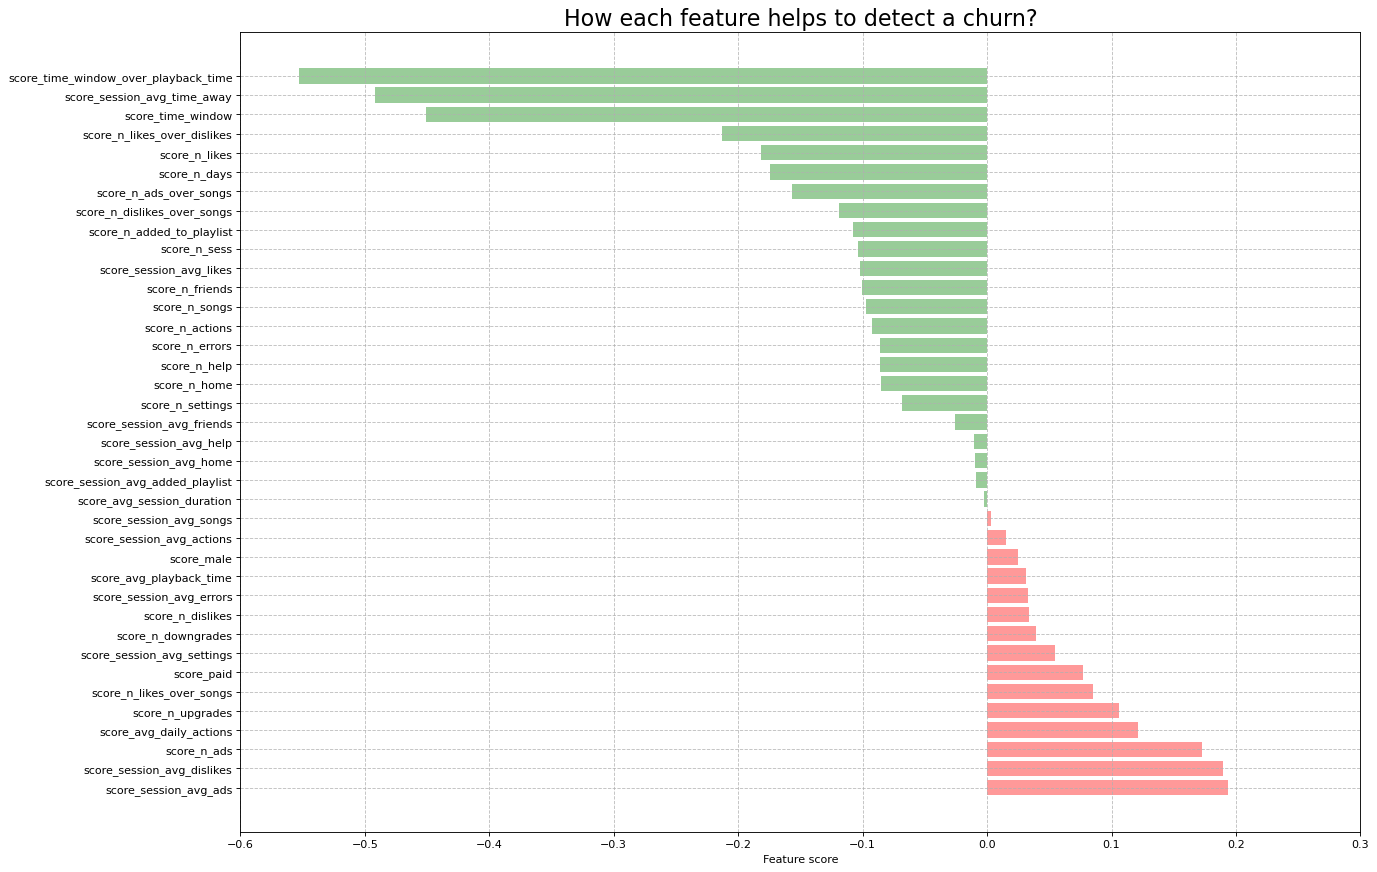

In [46]:
fig = plt.figure(figsize = (14, 10), dpi = 80)
ax = fig.add_axes([0, 0, 1, 1])
 
df_scores['colors'] = df_scores.score.apply(lambda score: 'green' if score < 0 else 'red')

ax.barh(list(df_scores.feature), list(df_scores.score), align = 'center', alpha = .4, linewidth = 5, color = list(df_scores.colors))

ax.set_xticks(list(np.around(np.arange(-.6, .4, .1), 3)))
 
ax.invert_yaxis()
ax.set_xlabel('Feature score')
ax.set_title('How each feature helps to detect a churn?', fontdict = { 'size' : 20 })

plt.grid(linestyle = '--', alpha = 0.8)
plt.xticks(rotation = 0)

plt.show()

# Data Modelling 

# Schema (New Dataset)

In [59]:
df_users.printSchema()

root
 |-- n_likes_over_dislikes: double (nullable = false)
 |-- n_dislikes: long (nullable = false)
 |-- session_avg_settings: double (nullable = false)
 |-- n_likes_over_songs: double (nullable = false)
 |-- n_help: long (nullable = false)
 |-- userId: string (nullable = true)
 |-- avg_playback_time: double (nullable = false)
 |-- n_actions: long (nullable = false)
 |-- session_avg_help: double (nullable = false)
 |-- n_settings: long (nullable = false)
 |-- n_ads_over_songs: double (nullable = false)
 |-- n_sess: long (nullable = false)
 |-- avg_session_duration: double (nullable = false)
 |-- session_avg_home: double (nullable = false)
 |-- n_downgrades: long (nullable = false)
 |-- canceled: integer (nullable = true)
 |-- session_avg_likes: double (nullable = false)
 |-- n_likes: long (nullable = false)
 |-- session_avg_dislikes: double (nullable = false)
 |-- n_songs: long (nullable = false)
 |-- n_upgrades: long (nullable = false)
 |-- n_ads: long (nullable = false)
 |-- n_days: 

# Checking the new data 

In [63]:
df_users.toPandas().head()

,n_likes_over_dislikes,n_dislikes,session_avg_settings,n_likes_over_songs,n_help,userId,avg_playback_time,n_actions,session_avg_help,n_settings,...,zscore_session_avg_errors,zscore_session_avg_friends,zscore_session_avg_help,zscore_session_avg_home,zscore_session_avg_likes,zscore_session_avg_settings,zscore_session_avg_songs,zscore_session_avg_time_away,zscore_time_window,zscore_time_window_over_playback_time
0,1.606061,33,0.119249,19.283019,8,1000280,3.430554,1317,0.105999,9,...,0.409989,0.260926,0.131335,0.291745,0.184767,0.029045,0.505312,0.625989,0.111889,0.230421
1,6.571429,14,0.081237,19.326087,12,1002185,7.240974,2080,0.097484,10,...,0.040739,0.207305,0.057829,0.431666,0.054254,0.150343,0.315745,0.398114,0.900728,0.253474
2,1.750000,4,0.170694,35.714286,1,1017805,5.858428,320,0.056898,3,...,0.352332,1.428038,0.292544,0.323094,1.063690,0.271826,0.116130,1.019584,0.862618,0.084104
3,4.125000,16,0.121283,22.303030,10,1030587,11.243422,1752,0.080855,15,...,0.197268,0.259498,0.085726,0.383644,0.672288,0.038643,1.996805,0.202094,0.436338,0.250699
4,3.333333,3,0.060997,23.600000,2,1033297,3.278877,299,0.121993,1,...,0.352332,0.082674,0.269405,0.239381,0.451603,0.245862,0.271376,0.388190,0.415199,0.027823


# Selecting the output label and setting the split ratio

In [68]:
CHURN_LABEL = 'canceled'
TRAIN_SPLIT_RATIO = .7
TEST_SPLIT_RATIO = .3

SPLIT_RATIO = [TRAIN_SPLIT_RATIO, TEST_SPLIT_RATIO]

# Confusion matrix and creating model classifier pipeline 

In [69]:
def plot_confusion_matrix(y_test, y_predictions):
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])
    tn = cm[1, 1]
    tp = cm[0, 0]
    fp = cm[1, 0]
    fn = cm[0, 1]
    
    total = np.sum(cm)
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 
    print(cm)

def create_pipeline(model):
    
    l_indexer = StringIndexer(inputCol = CHURN_LABEL, outputCol = 'idx_labels')
    f_binaries = VectorAssembler(inputCols = binary_features, outputCol = 'bin_features')
    f_numeric = VectorAssembler(inputCols = numeric_features, outputCol = 'num_features')
    f_scaler = StandardScaler(inputCol = 'num_features', outputCol = 'num_features_escaled', withStd = True, withMean = True)
    f_all = VectorAssembler(inputCols = [ 'bin_features' , 'num_features_escaled' ], outputCol = 'features')
    pipeline = Pipeline(stages = [ l_indexer, f_binaries, f_numeric, f_scaler, f_all, model ])
    return pipeline

def create_random_forest_pipeline():
    rf_classifier = RandomForestClassifier(labelCol = 'canceled', featuresCol = 'features', seed = 42)
    return create_pipeline(rf_classifier)

def create_gradient_boost_pipeline():
    gbt_classifier = GBTClassifier(labelCol = 'canceled', maxDepth = 5, maxIter = 100, seed = 42)
    return create_pipeline(gbt_classifier)

def create_logistic_regression_pipeline():
    lr_classifier = LogisticRegression(featuresCol = 'features', labelCol = 'idx_labels', weightCol = 'class_weights') 
    return create_pipeline(lr_classifier)

def create_decision_tree_pipeline():
    dt_classifier = DecisionTreeClassifier(labelCol = 'canceled', featuresCol = 'features', seed = 42)
    return create_pipeline(dt_classifier)

# Model Evaluation Metrics 

In [80]:
import uuid

from pyspark.ml.evaluation import Evaluator

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression  

class Recall(Evaluator):
    
    def __init__(self, predictionCol = 'prediction', labelCol = 'label'):
        self.predictionCol = predictionCol
        self.labelCol = labelCol
        self.uid = str(uuid.uuid4())

    def evaluate(self, dataset):
        
        tp = dataset.where((dataset[self.labelCol] == 1) & (dataset[self.predictionCol] == 1)).count()
        fp = dataset.where((dataset[self.labelCol] == 0) & (dataset[self.predictionCol] == 1)).count()
        tn = dataset.where((dataset[self.labelCol] == 0) & (dataset[self.predictionCol] == 0)).count()
        fn = dataset.where((dataset[self.labelCol] == 1) & (dataset[self.predictionCol] == 0)).count()

        return (100 / (tp + fn )) * tp

    def isLargerBetter(self):
        return True
    
from sklearn.metrics import f1_score, fbeta_score, make_scorer, roc_auc_score

 
beta_scorer = make_scorer(fbeta_score, average = 'binary', beta = 2)

def get_beta_score(y_test, y_predict):
    return fbeta_score(y_test, y_predict, average = 'binary', labels = [1, 0], beta = 2)
    
def plot_metrics(y_test, y_predictions):
    
    auc = roc_auc_score(y_test, y_predictions)
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])
    
    tn = cm[1, 1]
    tp = cm[0, 0]
    fp = cm[1, 0]
    fn = cm[0, 1]
    
    total = np.sum(cm)
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 

    beta = get_beta_score(y_test, y_predictions)
    
    f1_binary = f1_score(y_test, y_predictions, average = 'binary', labels = [1, 0])
    f1_macro = f1_score(y_test, y_predictions, average = 'macro')
    f1_micro = f1_score(y_test, y_predictions, average = 'micro')
    f1_weighted = f1_score(y_test, y_predictions, average = 'weighted')
    
    print(cm)
    print('')
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('auc......................%7.4f' % auc)
    print('beta.....................%7.4f' % beta)
    print('F1 macro.................%7.4f' % f1_macro)
    print('F1 micro.................%7.4f' % f1_micro)
    print('F1 weighted..............%7.4f' % f1_weighted) 
    print('F1 binary................%7.4f' %  f1_binary)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'f1_weighted': f1_weighted,
        'binary': f1_binary,
        'beta': beta,
        'tp': int(tp),
        'fn': int(fn),
        'fp': int(fp),
        'tn': int(tn),
        'y_test': str(list(y_test.values)),
        'y_predictions': str(list(y_predictions.values))
    }

# Saving the best model and its hyperparmaters locally

In [84]:
import pandas as pd 

def show_results_and_save(model_pipeline, predictions):
    
    df_results = predictions.select(['canceled', 'prediction']).toPandas()
    df_results['prediction'] = df_results.prediction.apply(int)

    # Display the results
    _metrics = plot_metrics(df_results['canceled'], df_results['prediction'])
    
    # Save the results
    _model = model_pipeline.stages[-1]
    _model_name = _model.__class__.__name__

    _model_info = {
        'model_name' : _model_name,
        'hyperparameters' : list(zip(list(map(lambda _param: _param.name, list(_model.extractParamMap()))), list(_model.extractParamMap().values())))
    }

    _metrics.update(_model_info)

    _df_metrics = pd.DataFrame([_metrics])
    _df_metrics.to_csv(f'spark_{_model_name}.csv', index = False)

# Splitting the data into 70/30 ratio. 

In [70]:
(train_df, test_df) = df_users.randomSplit(SPLIT_RATIO, seed = 42)

In [71]:
train_df.cache()
test_df.cache()

DataFrame[n_likes_over_dislikes: double, n_dislikes: bigint, session_avg_settings: double, n_likes_over_songs: double, n_help: bigint, userId: string, avg_playback_time: double, n_actions: bigint, session_avg_help: double, n_settings: bigint, n_ads_over_songs: double, n_sess: bigint, avg_session_duration: double, session_avg_home: double, n_downgrades: bigint, canceled: int, session_avg_likes: double, n_likes: bigint, session_avg_dislikes: double, n_songs: bigint, n_upgrades: bigint, n_ads: bigint, n_days: bigint, time_window: double, n_added_to_playlist: bigint, session_avg_friends: double, n_friends: bigint, n_dislikes_over_songs: double, avg_daily_actions: double, paid: int, session_avg_time_away: double, session_avg_ads: double, session_avg_errors: double, session_avg_actions: double, n_home: bigint, session_avg_added_playlist: double, n_errors: bigint, time_window_over_playback_time: double, male: int, session_avg_songs: double, zscore_avg_daily_actions: double, zscore_avg_session

In [75]:
balancing_ratio = train_df.filter(train_df.canceled == 0).count() / train_df.count()
train_df = train_df.withColumn('class_weights', when(train_df.canceled == 1, balancing_ratio).otherwise(1 - balancing_ratio))

# Splitting the full dataset into train, test, and validation sets. Testing out several of the machine learning methods to achieve a good accuracy 

### Logistic Regression 

In [86]:
pipeline = create_logistic_regression_pipeline()
model_pipeline = pipeline.fit(train_df)
predictions = model_pipeline.transform(test_df)
show_results_and_save(model_pipeline, predictions)

[[1085  253]
 [ 609 3941]]

accuracy................. 0.8536
precision................ 0.6405
recall................... 0.8109
auc...................... 0.8385
beta..................... 0.7699
F1 macro................. 0.8086
F1 micro................. 0.8536
F1 weighted.............. 0.8592
F1 binary................ 0.7157


### Decision Tree Classifier 

In [87]:
pipeline1 = create_decision_tree_pipeline()
model_pipeline1 = pipeline1.fit(train_df)
predictions1 = model_pipeline1.transform(test_df)
show_results_and_save(model_pipeline1, predictions1)

[[ 841  497]
 [ 139 4411]]

accuracy................. 0.8920
precision................ 0.8582
recall................... 0.6286
auc...................... 0.7990
beta..................... 0.6641
F1 macro................. 0.8292
F1 micro................. 0.8920
F1 weighted.............. 0.8857
F1 binary................ 0.7256


### Random Forest 

In [89]:
pipeline2 = create_random_forest_pipeline()
model_pipeline2 = pipeline2.fit(train_df)
predictions2 = model_pipeline2.transform(test_df)
show_results_and_save(model_pipeline2, predictions2)

[[ 804  534]
 [ 100 4450]]

accuracy................. 0.8923
precision................ 0.8894
recall................... 0.6009
auc...................... 0.7895
beta..................... 0.6426
F1 macro................. 0.8254
F1 micro................. 0.8923
F1 weighted.............. 0.8844
F1 binary................ 0.7172


### Gradient Boost

In [ ]:
pipeline3 = create_gradient_boost_pipeline()
model_pipeline3 = pipeline3.fit(train_df)
predictions3 = model_pipeline.transform(test_df)
show_results_and_save(model_pipeline3, predictions3)